In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

import seaborn as sns; sns.set_palette("Set1")
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("dataTransformation").getOrCreate()

heart = spark.read.csv("cleaned_heart.csv", header=True)
heart.show(5)


23/10/11 22:19:35 WARN Utils: Your hostname, Stephens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
23/10/11 22:19:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 22:19:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/11 22:19:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/11 22:19:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/10/11 22:19:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---+----------------------+-----------+-------------------+-------------+-----------------------+-----------------------+-------------+-----------------+------+-------+-------------------+----------------+-------------------+---------+----------------------------+--------------------------------+-------------------------------+------------------------------+------------------+-------------------------+-----------------------+----------------------------------+-----------------------+-----------------------------+
|age|sex|resting_blood_pressure|cholesterol|fasting_blood_sugar|rest_ecg_type|max_heart_rate_achieved|exercise_induced_angina|st_depression|num_major_vessels|target|retired|high_blood_pressure|vessels_coloured|non_zero_depression|partition|chest_pain_type_asymptomatic|chest_pain_type_non-anginal_pain|chest_pain_type_atypical_angina|chest_pain_type_typical_angina|st_slope_type_flat|st_slope_type_downsloping|st_slope_type_upsloping|thalassemia_type_reversible_defect|thalass

In [2]:
float_cols = ["st_depression"]

int_cols = ['age',
            'sex',
            'resting_blood_pressure',
            'cholesterol',
            'fasting_blood_sugar',
            'rest_ecg_type',
            'max_heart_rate_achieved',
            'exercise_induced_angina',
            'num_major_vessels',
            'target',
            'retired',
            'high_blood_pressure',
            'vessels_coloured',
            'non_zero_depression',
            'chest_pain_type_asymptomatic',
            'chest_pain_type_non-anginal_pain',
            'chest_pain_type_atypical_angina',
            'chest_pain_type_typical_angina',
            'st_slope_type_flat',
            'st_slope_type_downsloping',
            'st_slope_type_upsloping',
            'thalassemia_type_reversible_defect',
            'thalassemia_type_normal',
            'thalassemia_type_fixed_defect']

string_cols = ['partition']

for column in [col for col in float_cols]:
    heart = heart.withColumn(column, heart[column].cast('float'))

for column in [col for col in int_cols]:
    heart = heart.withColumn(column, heart[column].cast('int'))

for column in [col for col in string_cols]:
    heart = heart.withColumn(column, heart[column].cast('string'))
    
heart.printSchema()

train = heart.filter(col("partition") == "train").drop("partition")
test = heart.filter(col("partition") == "test").drop("partition")
train.show(5)

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- resting_blood_pressure: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- fasting_blood_sugar: integer (nullable = true)
 |-- rest_ecg_type: integer (nullable = true)
 |-- max_heart_rate_achieved: integer (nullable = true)
 |-- exercise_induced_angina: integer (nullable = true)
 |-- st_depression: float (nullable = true)
 |-- num_major_vessels: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- retired: integer (nullable = true)
 |-- high_blood_pressure: integer (nullable = true)
 |-- vessels_coloured: integer (nullable = true)
 |-- non_zero_depression: integer (nullable = true)
 |-- partition: string (nullable = true)
 |-- chest_pain_type_asymptomatic: integer (nullable = true)
 |-- chest_pain_type_non-anginal_pain: integer (nullable = true)
 |-- chest_pain_type_atypical_angina: integer (nullable = true)
 |-- chest_pain_type_typical_angina: integer (nullable = 

23/10/11 22:20:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


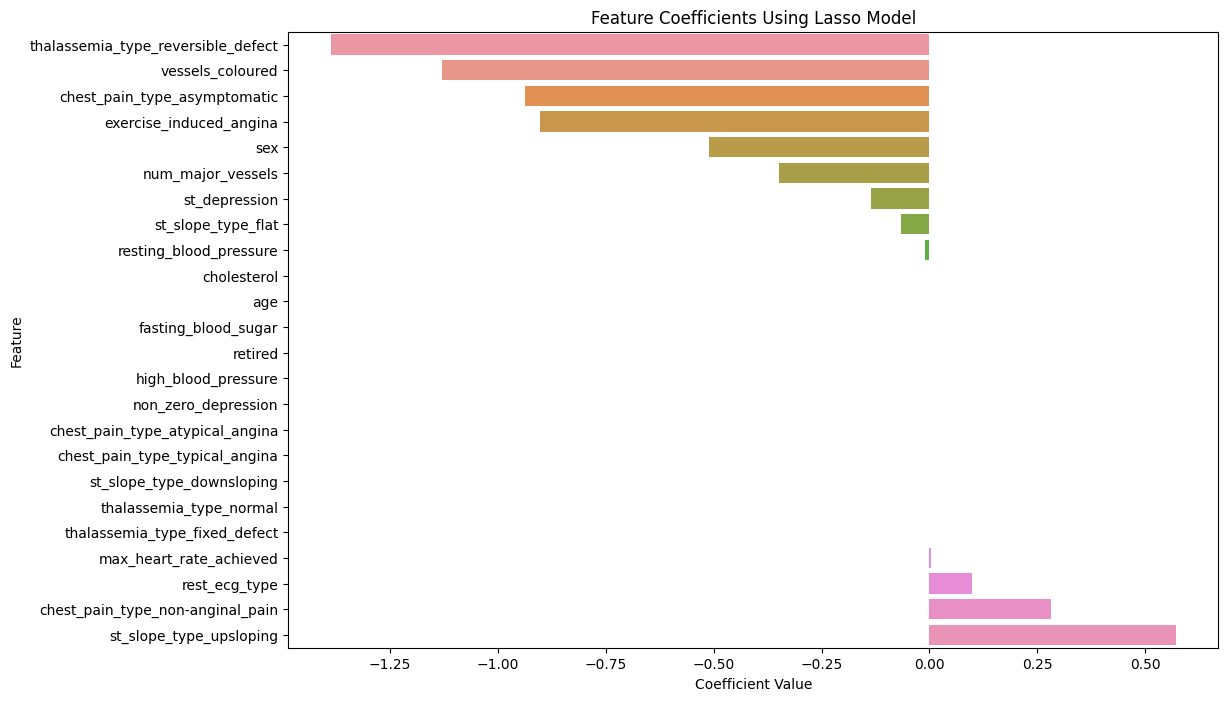

In [3]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import pandas as pd

feature_columns = [col_name for col_name in train.columns if col_name != "target"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

lasso_train = assembler.transform(train)

lasso = LogisticRegression(featuresCol="features",
                         labelCol="target", 
                         elasticNetParam=1.0, 
                         regParam=0.03,
                         fitIntercept=True)


lasso_model = lasso.fit(lasso_train)

coefficients = lasso_model.coefficients.toArray()
coef_scores = sorted(list(zip(feature_columns, coefficients)), key=lambda x: x[1])
feature_importance = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Importance"])

# Create a barplot to visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=feature_importance)
plt.title("Feature Coefficients Using Lasso Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

In [4]:
from pprint import pprint

dropped_variables = [coef for coef, score in coef_scores if score == 0]
pprint(dropped_variables)

heart = heart.drop(*dropped_variables)

train = heart.filter(col("partition") == "train").drop("partition")
test = heart.filter(col("partition") == "test").drop("partition")

print(train.printSchema())


['age',
 'fasting_blood_sugar',
 'retired',
 'high_blood_pressure',
 'non_zero_depression',
 'chest_pain_type_atypical_angina',
 'chest_pain_type_typical_angina',
 'st_slope_type_downsloping',
 'thalassemia_type_normal',
 'thalassemia_type_fixed_defect']
root
 |-- sex: integer (nullable = true)
 |-- resting_blood_pressure: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- rest_ecg_type: integer (nullable = true)
 |-- max_heart_rate_achieved: integer (nullable = true)
 |-- exercise_induced_angina: integer (nullable = true)
 |-- st_depression: float (nullable = true)
 |-- num_major_vessels: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- vessels_coloured: integer (nullable = true)
 |-- chest_pain_type_asymptomatic: integer (nullable = true)
 |-- chest_pain_type_non-anginal_pain: integer (nullable = true)
 |-- st_slope_type_flat: integer (nullable = true)
 |-- st_slope_type_upsloping: integer (nullable = true)
 |-- thalassemia_type_reversible

In [5]:
from ydata_profiling import ProfileReport
continuous_cols = ["st_depression", 
                    "cholesterol",
                    "resting_blood_pressure", 
                    "max_heart_rate_achieved"]

transform_data = train.select(continuous_cols)


transform_report = ProfileReport(transform_data)
transform_report.to_file("pre_transform.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

23/10/11 22:20:32 WARN CacheManager: Asked to cache already cached data.        
23/10/11 22:20:32 WARN CacheManager: Asked to cache already cached data.
23/10/11 22:20:32 WARN CacheManager: Asked to cache already cached data.
23/10/11 22:20:32 WARN CacheManager: Asked to cache already cached data.


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

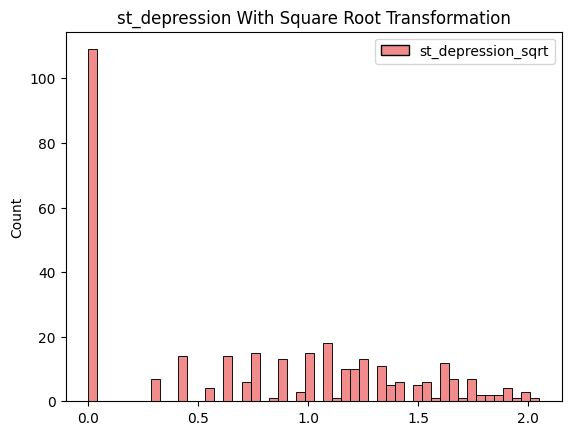

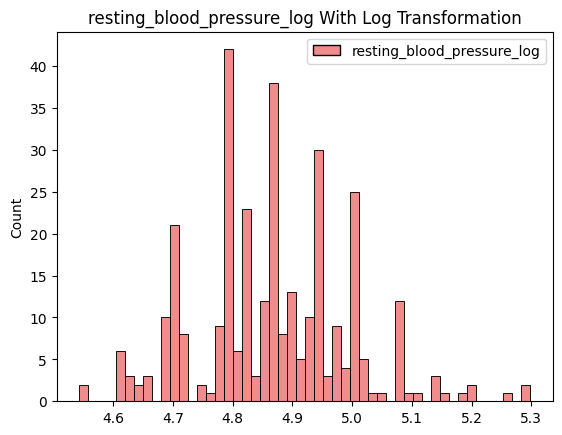

In [6]:
from pyspark.sql.functions import sqrt, log
from pyspark.sql import functions as F

# Square root transformation for 'st_depression'
train = train.withColumn("st_depression_sqrt", sqrt(train["st_depression"]))
train = train.withColumn("resting_blood_pressure_log", log(train["resting_blood_pressure"]))

# Show histograms (you may need to adjust the number of bins)
depress_sqrt = train.select("st_depression_sqrt").toPandas()
sns.histplot(depress_sqrt, bins=50)
plt.title("st_depression With Square Root Transformation")
plt.show()

rbp_log = train.select("resting_blood_pressure_log").toPandas()
sns.histplot(rbp_log, bins=50)
plt.title("resting_blood_pressure_log With Log Transformation")
plt.show()


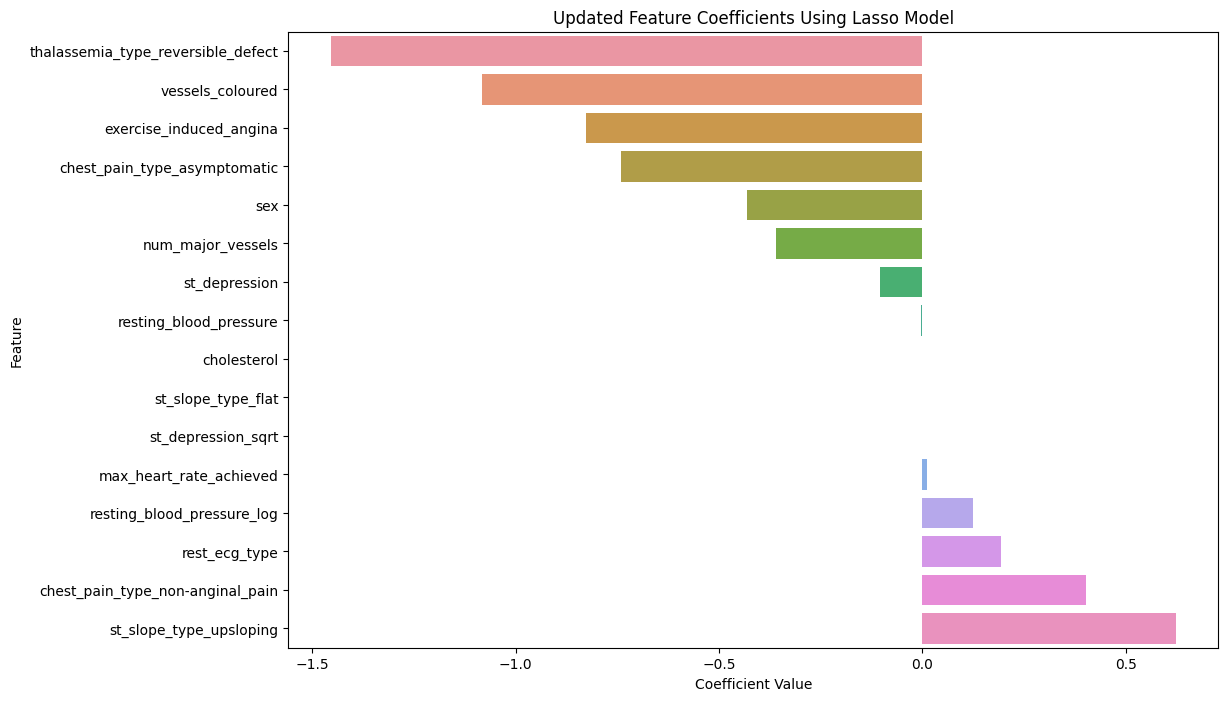

In [7]:
# Define the features and target columns
feature_columns = [col_name for col_name in train.columns if col_name != "target"]
target_column = "target"

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

transformed_train = assembler.transform(train)

lasso = LogisticRegression(featuresCol="features", 
                         labelCol=target_column, 
                         elasticNetParam=1.0, 
                         regParam=0.03,
                         fitIntercept=False)

lasso_model = lasso.fit(transformed_train)

coefficients = lasso_model.coefficients.toArray()

coef_scores = sorted(list(zip(feature_columns, coefficients)), key=lambda x: x[1])

feature_importance = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Importance"])

# Create a barplot to visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=feature_importance)
plt.title("Updated Feature Coefficients Using Lasso Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


In [9]:
dropped_variables = [coef for coef, score in coef_scores if score == 0 and coef in heart.columns]
pprint(dropped_variables)
heart = heart.drop(*dropped_variables)
heart = heart.withColumn("resting_blood_pressure_log", log(train["resting_blood_pressure"]))

train = heart.filter(col("partition") == "train").drop("partition")
test = heart.filter(col("partition") == "test").drop("partition")
train.show(5)

['cholesterol', 'st_slope_type_flat']
+---+----------------------+-------------+-----------------------+-----------------------+-------------+-----------------+------+----------------+----------------------------+--------------------------------+-----------------------+----------------------------------+--------------------------+
|sex|resting_blood_pressure|rest_ecg_type|max_heart_rate_achieved|exercise_induced_angina|st_depression|num_major_vessels|target|vessels_coloured|chest_pain_type_asymptomatic|chest_pain_type_non-anginal_pain|st_slope_type_upsloping|thalassemia_type_reversible_defect|resting_blood_pressure_log|
+---+----------------------+-------------+-----------------------+-----------------------+-------------+-----------------+------+----------------+----------------------------+--------------------------------+-----------------------+----------------------------------+--------------------------+
|  1|                   130|            0|                    202|           

## Balance target variable

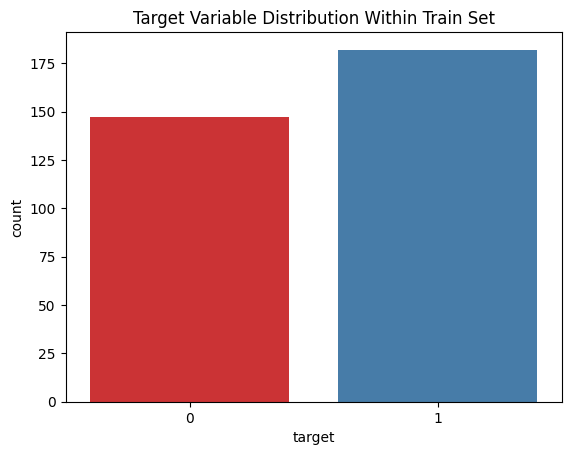

In [10]:
sns.countplot(data=train.toPandas(), x='target')
plt.title("Target Variable Distribution Within Train Set")
plt.show()

In [11]:
from imblearn.over_sampling import SMOTE

train = train.toPandas()

train_x, train_y = train.drop("target",axis=1), train["target"]

sm = SMOTE(random_state=722)
new_x,new_y = sm.fit_resample(train_x, train_y)

train = new_x
train["target"] = new_y

train = spark.createDataFrame(train)

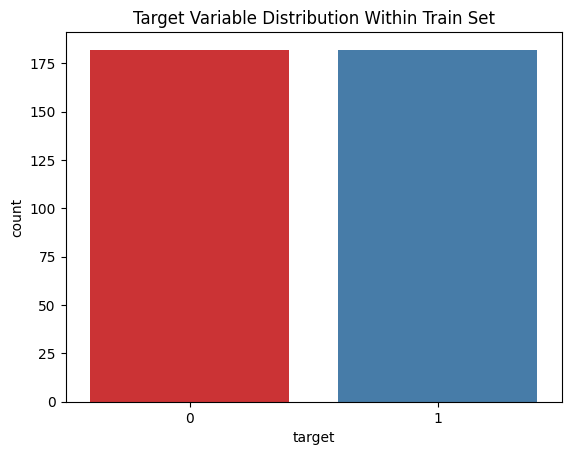

In [12]:


sns.countplot(data=train.toPandas(), x='target')
plt.title("Target Variable Distribution Within Train Set")
plt.show()

In [13]:
from pyspark.sql.functions import lit

# Add a "partition" column to train and test DataFrames
train = train.withColumn("partition", lit("train"))
test = test.withColumn("partition", lit("test"))

heart = train.unionByName(test)


print(spark.createDataFrame(heart.describe().toPandas().transpose().reset_index()).show(truncate=False))
print(heart.printSchema())

+----------------------------------+-----+-------------------+-------------------+-----------------+-----------------+
|index                             |0    |1                  |2                  |3                |4                |
+----------------------------------+-----+-------------------+-------------------+-----------------+-----------------+
|summary                           |count|mean               |stddev             |min              |max              |
|sex                               |447  |0.6868008948545862 |0.4643142522497525 |0                |1                |
|resting_blood_pressure            |447  |131.40939597315437 |17.289806254177034 |94               |200              |
|rest_ecg_type                     |447  |0.4899328859060403 |0.5004587536405618 |0                |1                |
|max_heart_rate_achieved           |447  |148.48322147651007 |23.25668929090527  |71               |202              |
|exercise_induced_angina           |447  |0.3199

In [14]:

float_cols = ["st_depression"]

string_cols = ['partition']

for column in [col for col in float_cols]:
    heart = heart.withColumn(column, heart[column].cast('float'))

for column in [col for col in string_cols]:
    heart = heart.withColumn(column, heart[column].cast('string'))

for column in [col for col in heart.columns if (col not in float_cols) and (col not in string_cols)]:
    heart = heart.withColumn(column, heart[column].cast('int'))

print(heart.printSchema())

heart.toPandas().to_csv("prepared_heart_data.csv", index=False, header=heart.columns)

root
 |-- sex: integer (nullable = true)
 |-- resting_blood_pressure: integer (nullable = true)
 |-- rest_ecg_type: integer (nullable = true)
 |-- max_heart_rate_achieved: integer (nullable = true)
 |-- exercise_induced_angina: integer (nullable = true)
 |-- st_depression: float (nullable = true)
 |-- num_major_vessels: integer (nullable = true)
 |-- vessels_coloured: integer (nullable = true)
 |-- chest_pain_type_asymptomatic: integer (nullable = true)
 |-- chest_pain_type_non-anginal_pain: integer (nullable = true)
 |-- st_slope_type_upsloping: integer (nullable = true)
 |-- thalassemia_type_reversible_defect: integer (nullable = true)
 |-- resting_blood_pressure_log: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- partition: string (nullable = false)

None


In [15]:
train_report = ProfileReport(train.toPandas())
test_report = ProfileReport(test.toPandas())
train_report.to_file("final_train.html")
test_report.to_file("final_test.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

23/10/12 01:07:39 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 255861 ms exceeds timeout 120000 ms
23/10/12 01:07:39 WARN SparkContext: Killing executors is not supported by current scheduler.
23/10/12 01:07:39 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o